# Оценка моделей на тестовых данных

Оценка обученных моделей сегментации (UNet-ResNet50) и детекции (Faster R-CNN) на тестовом наборе Inria Aerial Image Labeling Dataset.

**Тестовые города** (не участвовали в обучении):
- Bellingham, WA (США)
- Bloomington, IN (США)
- Innsbruck (Австрия)
- San Francisco, CA (США)
- East Tyrol (Австрия)

**Метрики сегментации**: IoU, Accuracy, Precision, Recall, F1, MAE/MAPE площади (м²)

**Метрики детекции**: mAP@0.5, mAP@[0.5:0.95], MAE/MAPE площади (м²)

**Данные**: 50 изображений с GT масками (10 на город), разрешение 0.3 м/пиксель

## 1. Импорты и конфигурация

In [1]:
from __future__ import annotations

import json
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import torch
from torchvision.ops import nms
from tqdm import tqdm

# Добавляем корень проекта в путь для импортов
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Подавление предупреждений
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=FutureWarning, module="rasterio")
warnings.filterwarnings("ignore", message="Dataset has no geotransform")

In [2]:
# Импорты из проекта
from src.datasets import IMAGENET_MEAN, IMAGENET_STD, mask_to_bboxes
from src.models import BuildingDetector, UNet
from src.utils import (
    calculate_area_from_boxes,
    calculate_area_m2,
    calculate_iou,
    calculate_map,
    calculate_pixel_metrics,
    load_checkpoint,
    seed_everything,
)

In [3]:
# ==================== CONFIGURATION ====================

# Paths
TEST_IMAGES_DIR = project_root / "data" / "raw" / "test" / "images"
TEST_GT_DIR = project_root / "data" / "processed" / "test" / "gt"
SEG_CHECKPOINT = project_root / "checkpoints" / "segmentation" / "seg_final_model.pth"
DET_CHECKPOINT = project_root / "checkpoints" / "detection" / "det_final_model.pth"
OUTPUT_DIR = project_root / "checkpoints" / "test_evaluation"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Проверка существования директорий с данными
if not TEST_IMAGES_DIR.exists():
    raise FileNotFoundError(f"Test images directory not found: {TEST_IMAGES_DIR}")
if not TEST_GT_DIR.exists():
    raise FileNotFoundError(f"Test GT directory not found: {TEST_GT_DIR}")

# Dataset parameters
GSD = 0.3  # Ground Sampling Distance (meters/pixel)
SEED = 42

# Inference parameters
SEG_TILE_SIZE = 512
SEG_OVERLAP = 64
DET_TILE_SIZE = 800
DET_OVERLAP = 100
DET_SCORE_THRESH = 0.5
DET_NMS_THRESH = 0.5

# City mapping
CITY_MAPPING = {
    "bellingham": "Bellingham, WA",
    "bloomington": "Bloomington, IN",
    "innsbruck": "Innsbruck, Austria",
    "sfo": "San Francisco, CA",
    "tyrol-e": "East Tyrol, Austria",
}

seed_everything(SEED)
print(f"Random seed: {SEED}")

Random seed: 42


In [4]:
# Device setup with GPU optimizations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

if torch.cuda.is_available():
    gpu_props = torch.cuda.get_device_properties(0)
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {gpu_props.total_memory / 1e9:.1f} GB")
    
    # TF32 for Ampere GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    print("TF32 + cuDNN benchmark enabled")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
Memory: 25.4 GB
TF32 + cuDNN benchmark enabled


## 2. Загрузка тестовых данных

In [5]:
def get_city_from_filename(filename: str) -> str:
    """Extract city name from filename."""
    name = Path(filename).stem.lower()
    for city in CITY_MAPPING.keys():
        if name.startswith(city):
            return city
    raise ValueError(f"Unknown city in filename: {filename}")


def get_test_image_paths() -> list[tuple[Path, Path, str]]:
    """Get paths to test images that have GT masks.
    
    Returns:
        List of (image_path, gt_path, city) tuples.
    """
    pairs = []
    
    for gt_path in sorted(TEST_GT_DIR.glob("*.tif")):
        image_path = TEST_IMAGES_DIR / gt_path.name
        if not image_path.exists():
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        city = get_city_from_filename(gt_path.name)
        pairs.append((image_path, gt_path, city))
    
    return pairs


def load_image(path: Path) -> np.ndarray:
    """Load image using rasterio.
    
    Returns:
        Image array (H, W, 3) in uint8 [0, 255].
    """
    with rasterio.open(path) as src:
        # Read as (C, H, W) -> transpose to (H, W, C)
        image = src.read([1, 2, 3]).transpose(1, 2, 0)
    # Гарантируем uint8 формат (rasterio может вернуть другой dtype)
    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)
    return image


def load_gt_mask(path: Path) -> np.ndarray:
    """Load ground truth binary mask.
    
    Returns:
        Binary mask (H, W) with values 0 or 1.
    """
    with rasterio.open(path) as src:
        mask = src.read(1)
    # Бинаризация (маски могут быть 0/255)
    return (mask > 0).astype(np.uint8)

In [6]:
# Загрузка списка тестовых данных
test_pairs = get_test_image_paths()
if not test_pairs:
    raise ValueError(
        f"No test image-mask pairs found.\n"
        f"Check that GT masks exist in: {TEST_GT_DIR}\n"
        f"and corresponding images exist in: {TEST_IMAGES_DIR}"
    )
print(f"Found {len(test_pairs)} test image-mask pairs")

# Статистика по городам
city_counts = {}
for _, _, city in test_pairs:
    city_counts[city] = city_counts.get(city, 0) + 1

print("\nImages per city:")
for city, count in sorted(city_counts.items()):
    print(f"  {CITY_MAPPING[city]}: {count}")

Found 50 test image-mask pairs

Images per city:
  Bellingham, WA: 10
  Bloomington, IN: 10
  Innsbruck, Austria: 10
  San Francisco, CA: 10
  East Tyrol, Austria: 10


## 3. Загрузка моделей

In [7]:
def load_segmentation_model(checkpoint_path: Path) -> UNet:
    """Load trained UNet segmentation model."""
    if not checkpoint_path.exists():
        raise FileNotFoundError(
            f"Segmentation checkpoint not found: {checkpoint_path}\n"
            "Please train the model first using 04_segmentation_training.ipynb"
        )
    
    model = UNet(num_classes=1, pretrained_encoder=False)
    checkpoint = load_checkpoint(checkpoint_path, model, device=DEVICE)
    model = model.to(DEVICE)
    model.eval()
    
    print(f"Loaded segmentation model from epoch {checkpoint.get('epoch', 'N/A')}")
    return model


def load_detection_model(checkpoint_path: Path) -> BuildingDetector:
    """Load trained Faster R-CNN detection model."""
    if not checkpoint_path.exists():
        raise FileNotFoundError(
            f"Detection checkpoint not found: {checkpoint_path}\n"
            "Please train the model first using 05_detection_training.ipynb"
        )
    
    model = BuildingDetector(
        pretrained_backbone=False,
        box_score_thresh=0.05,  # Низкий порог для PR curve
        box_nms_thresh=DET_NMS_THRESH,
    )
    checkpoint = load_checkpoint(checkpoint_path, model, device=DEVICE)
    model = model.to(DEVICE)
    model.eval()
    
    print(f"Loaded detection model from epoch {checkpoint.get('epoch', 'N/A')}")
    return model

In [8]:
# Загрузка моделей
seg_model = load_segmentation_model(SEG_CHECKPOINT)
det_model = load_detection_model(DET_CHECKPOINT)

# Подсчёт параметров
seg_params = sum(p.numel() for p in seg_model.parameters())
det_params = sum(p.numel() for p in det_model.parameters())
print(f"\nSegmentation model: {seg_params / 1e6:.1f}M parameters")
print(f"Detection model: {det_params / 1e6:.1f}M parameters")

Loaded segmentation model from epoch 30
Loaded detection model from epoch 100

Segmentation model: 47.5M parameters
Detection model: 41.3M parameters


## 4. Inference функции

In [9]:
def preprocess_image(image: np.ndarray) -> torch.Tensor:
    """Preprocess image for model input.
    
    Args:
        image: Image (H, W, 3) uint8 [0, 255]
    
    Returns:
        Normalized tensor (1, 3, H, W) float32
    """
    # Convert to float and normalize to [0, 1]
    img = image.astype(np.float32) / 255.0
    
    # ImageNet normalization
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    img = (img - mean) / std
    
    # HWC -> CHW -> BCHW
    img = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0)
    return img.float()


@torch.inference_mode()
def sliding_window_segmentation(
    model: UNet,
    image: np.ndarray,
    tile_size: int = 512,
    overlap: int = 64,
) -> np.ndarray:
    """Run segmentation with sliding window on full image.
    
    Args:
        model: Segmentation model
        image: Input image (H, W, 3)
        tile_size: Size of tiles
        overlap: Overlap between tiles
    
    Returns:
        Binary mask (H, W)
    """
    h, w = image.shape[:2]
    stride = tile_size - overlap
    
    # Выходной массив с весами для усреднения в overlap
    output = np.zeros((h, w), dtype=np.float32)
    weights = np.zeros((h, w), dtype=np.float32)
    
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            # Границы тайла
            y1, y2 = y, min(y + tile_size, h)
            x1, x2 = x, min(x + tile_size, w)
            
            # Извлечение тайла
            tile = image[y1:y2, x1:x2]
            
            # Padding если нужно
            pad_h = tile_size - tile.shape[0]
            pad_w = tile_size - tile.shape[1]
            if pad_h > 0 or pad_w > 0:
                tile = np.pad(tile, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
            
            # Inference
            tile_tensor = preprocess_image(tile).to(DEVICE)
            pred = model(tile_tensor)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()
            
            # Обрезка padding
            pred = pred[:y2 - y1, :x2 - x1]
            
            # Аккумулирование
            output[y1:y2, x1:x2] += pred
            weights[y1:y2, x1:x2] += 1.0
    
    # Усреднение в областях overlap
    output = output / np.maximum(weights, 1e-6)
    
    # Бинаризация
    return (output > 0.5).astype(np.uint8)

In [10]:
@torch.inference_mode()
def sliding_window_detection(
    model: BuildingDetector,
    image: np.ndarray,
    tile_size: int = 800,
    overlap: int = 100,
    score_thresh: float = 0.5,
    nms_thresh: float = 0.5,
) -> tuple[np.ndarray, np.ndarray]:
    """Run detection with sliding window on full image.
    
    Args:
        model: Detection model
        image: Input image (H, W, 3)
        tile_size: Size of tiles
        overlap: Overlap between tiles
        score_thresh: Minimum confidence score
        nms_thresh: NMS threshold
    
    Returns:
        boxes: (N, 4) array of [x1, y1, x2, y2]
        scores: (N,) array of confidence scores
    """
    h, w = image.shape[:2]
    stride = tile_size - overlap
    
    all_boxes = []
    all_scores = []
    
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            # Границы тайла
            y1, y2 = y, min(y + tile_size, h)
            x1, x2 = x, min(x + tile_size, w)
            
            # Извлечение тайла
            tile = image[y1:y2, x1:x2]
            
            # Preprocessing для detection (без padding, модель принимает разные размеры)
            tile_float = tile.astype(np.float32) / 255.0
            tile_tensor = torch.from_numpy(tile_float.transpose(2, 0, 1)).to(DEVICE)
            
            # Inference
            predictions = model([tile_tensor])[0]
            
            # Конвертация координат в глобальные
            boxes = predictions["boxes"].cpu().numpy()
            scores = predictions["scores"].cpu().numpy()
            
            if len(boxes) > 0:
                # Сдвиг координат
                boxes[:, [0, 2]] += x1
                boxes[:, [1, 3]] += y1
                
                all_boxes.append(boxes)
                all_scores.append(scores)
    
    if not all_boxes:
        return np.zeros((0, 4)), np.zeros((0,))
    
    # Объединение всех детекций
    all_boxes = np.vstack(all_boxes)
    all_scores = np.concatenate(all_scores)
    
    # Фильтрация по score
    mask = all_scores >= score_thresh
    all_boxes = all_boxes[mask]
    all_scores = all_scores[mask]
    
    if len(all_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,))
    
    # Global NMS
    boxes_tensor = torch.from_numpy(all_boxes).float()
    scores_tensor = torch.from_numpy(all_scores).float()
    keep = nms(boxes_tensor, scores_tensor, nms_thresh)
    
    return all_boxes[keep.numpy()], all_scores[keep.numpy()]

In [11]:
def boxes_to_mask(boxes: np.ndarray, shape: tuple[int, int]) -> np.ndarray:
    """Convert bounding boxes to binary mask.
    
    Args:
        boxes: (N, 4) array of [x1, y1, x2, y2]
        shape: (H, W) output shape
    
    Returns:
        Binary mask (H, W)
    """
    mask = np.zeros(shape, dtype=np.uint8)
    if len(boxes) == 0:
        return mask
    for box in boxes:
        x1, y1, x2, y2 = box.astype(int)
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(shape[1], x2)
        y2 = min(shape[0], y2)
        mask[y1:y2, x1:x2] = 1
    return mask

## 5. Оценка моделей на тестовых данных

In [12]:
# Структура для хранения результатов
results = []

# Кэш для предсказаний и GT масок (чтобы не пересчитывать в последующих ячейках)
predictions_cache = {}

# Списки для расчёта mAP на всём датасете
all_det_boxes = []
all_det_scores = []
all_gt_boxes = []

# Оценка на всех тестовых изображениях
for image_path, gt_path, city in tqdm(test_pairs, desc="Evaluating"):
    # Загрузка данных
    image = load_image(image_path)
    gt_mask = load_gt_mask(gt_path)
    h, w = gt_mask.shape
    
    # GT bboxes из маски
    gt_boxes = mask_to_bboxes(gt_mask, min_area=100)
    
    # === Segmentation ===
    seg_mask = sliding_window_segmentation(
        seg_model, image, tile_size=SEG_TILE_SIZE, overlap=SEG_OVERLAP
    )
    seg_metrics = calculate_pixel_metrics(seg_mask, gt_mask)
    seg_area = calculate_area_m2(seg_mask, gsd=GSD)
    gt_area = calculate_area_m2(gt_mask, gsd=GSD)
    
    # === Detection ===
    det_boxes, det_scores = sliding_window_detection(
        det_model, image, tile_size=DET_TILE_SIZE, overlap=DET_OVERLAP,
        score_thresh=DET_SCORE_THRESH, nms_thresh=DET_NMS_THRESH
    )
    
    # Detection metrics
    det_area = calculate_area_from_boxes(det_boxes, gsd=GSD)
    
    # Сбор данных для mAP на всём датасете
    all_det_boxes.append(det_boxes)
    all_det_scores.append(det_scores)
    all_gt_boxes.append(gt_boxes)
    
    # Detection IoU (boxes converted to mask)
    det_mask = boxes_to_mask(det_boxes, (h, w))
    det_iou = calculate_iou(det_mask, gt_mask)
    
    # Кэширование предсказаний и GT для визуализаций
    predictions_cache[image_path.name] = {
        "seg_mask": seg_mask,
        "det_boxes": det_boxes,
        "det_scores": det_scores,
        "gt_mask": gt_mask,
    }
    
    # Сохранение результатов
    results.append({
        "filename": image_path.name,
        "city": city,
        # Segmentation
        "seg_iou": seg_metrics.iou,
        "seg_accuracy": seg_metrics.accuracy,
        "seg_precision": seg_metrics.precision,
        "seg_recall": seg_metrics.recall,
        "seg_f1": seg_metrics.f1,
        "seg_area_m2": seg_area,
        # Detection
        "det_iou": det_iou,
        "det_area_m2": det_area,
        "det_num_boxes": len(det_boxes),
        # Ground truth
        "gt_area_m2": gt_area,
        "gt_num_boxes": len(gt_boxes),
    })
    
    # Очистка CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Вычисление mAP на всём датасете (правильный способ)
# mAP@0.5 вычисляется первым и используется повторно для COCO mAP
# Используем явный список порогов вместо np.arange для избежания проблем с float precision
COCO_IOU_THRESHOLDS = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
dataset_map50 = calculate_map(all_det_boxes, all_det_scores, all_gt_boxes, iou_threshold=0.5)
maps_coco = [dataset_map50]
for thresh in COCO_IOU_THRESHOLDS[1:]:  # Пропускаем 0.5, уже вычислен
    m = calculate_map(all_det_boxes, all_det_scores, all_gt_boxes, iou_threshold=thresh)
    maps_coco.append(m)
dataset_map_coco = np.mean(maps_coco)

print(f"\nEvaluation complete: {len(results)} images processed")
print(f"Dataset mAP@0.5: {dataset_map50:.4f}")
print(f"Dataset mAP@[0.5:0.95]: {dataset_map_coco:.4f}")

Evaluating: 100%|██████████| 50/50 [10:00<00:00, 12.01s/it]



Evaluation complete: 50 images processed
Dataset mAP@0.5: 0.4549
Dataset mAP@[0.5:0.95]: 0.2090


In [13]:
# Конвертация в DataFrame
df = pd.DataFrame(results)

# Добавление ошибок площади
df["seg_area_error"] = df["seg_area_m2"] - df["gt_area_m2"]
df["det_area_error"] = df["det_area_m2"] - df["gt_area_m2"]

# MAPE: пропускаем изображения без зданий (gt_area = 0)
# Используем np.where чтобы избежать деления на ноль
df["seg_area_error_pct"] = np.where(
    df["gt_area_m2"] > 0,
    (df["seg_area_error"].abs() / df["gt_area_m2"]) * 100,
    np.nan
)
df["det_area_error_pct"] = np.where(
    df["gt_area_m2"] > 0,
    (df["det_area_error"].abs() / df["gt_area_m2"]) * 100,
    np.nan
)

df.head()

,filename,city,seg_iou,seg_accuracy,seg_precision,seg_recall,seg_f1,seg_area_m2,det_iou,det_area_m2,det_num_boxes,gt_area_m2,gt_num_boxes,seg_area_error,det_area_error,seg_area_error_pct,det_area_error_pct
0,bellingham1.tif,bellingham,0.621974,0.961571,0.825736,0.715952,0.766935,172286.82,0.553131,231064.406250,775,198705.15,513,-26418.33,32359.256250,13.295242,16.285062
1,bellingham10.tif,bellingham,0.590593,0.946309,0.781810,0.707149,0.742607,222903.27,0.456242,200495.531250,747,246437.46,515,-23534.19,-45941.928750,9.549762,18.642429
2,bellingham11.tif,bellingham,0.585462,0.922153,0.694967,0.787938,0.738538,355956.66,0.436366,345996.406250,1108,313956.09,731,42000.57,32040.316250,13.377848,10.205349
3,bellingham12.tif,bellingham,0.341762,0.974185,0.554464,0.471149,0.509422,54389.70,0.340890,63638.609375,290,64007.55,148,-9617.85,-368.940625,15.026118,0.576402
4,bellingham13.tif,bellingham,0.628023,0.983313,0.769786,0.773254,0.771516,82348.47,0.562107,111063.132812,445,81979.11,283,369.36,29084.022812,0.450554,35.477359


## 6. Результаты по городам

In [14]:
# Агрегация по городам
city_metrics = df.groupby("city").agg({
    # Segmentation
    "seg_iou": "mean",
    "seg_f1": "mean",
    "seg_precision": "mean",
    "seg_recall": "mean",
    "seg_area_error": lambda x: x.abs().mean(),
    "seg_area_error_pct": "mean",
    # Detection (mAP вычисляется на уровне датасета, не по городам)
    "det_iou": "mean",
    "det_area_error": lambda x: x.abs().mean(),
    "det_area_error_pct": "mean",
    # Count
    "filename": "count",
}).rename(columns={
    "filename": "num_images",
    "seg_area_error": "seg_mae_m2",
    "det_area_error": "det_mae_m2",
    "seg_area_error_pct": "seg_mape",
    "det_area_error_pct": "det_mape",
})

city_metrics

,seg_iou,seg_f1,seg_precision,seg_recall,seg_mae_m2,seg_mape,det_iou,det_mae_m2,det_mape,num_images
city,,,,,,,,,,
bellingham,0.516615,0.661833,0.740170,0.641745,64057.086,16.301735,0.454401,65253.627531,18.531142,10
bloomington,0.554357,0.705598,0.769659,0.676663,22252.185,17.315932,0.460920,30579.147109,24.477165,10
innsbruck,0.586759,0.732554,0.821983,0.682977,65255.976,18.295314,0.428849,138009.832375,37.379188,10
sfo,0.406601,0.575852,0.458284,0.803762,237719.844,82.501731,0.327438,258605.193125,91.281720,10
tyrol-e,0.691382,0.814731,0.907146,0.743072,31200.426,18.146882,0.537505,54959.070250,39.592457,10


In [15]:
# Общие метрики
overall_metrics = {
    "Segmentation": {
        "IoU": df["seg_iou"].mean(),
        "F1": df["seg_f1"].mean(),
        "Precision": df["seg_precision"].mean(),
        "Recall": df["seg_recall"].mean(),
        "MAE (m2)": df["seg_area_error"].abs().mean(),
        "MAPE (%)": df["seg_area_error_pct"].mean(),
    },
    "Detection": {
        "mAP@0.5": dataset_map50,  # Вычислено на всём датасете
        "mAP@[0.5:0.95]": dataset_map_coco,  # Вычислено на всём датасете
        "IoU (from boxes)": df["det_iou"].mean(),
        "MAE (m2)": df["det_area_error"].abs().mean(),
        "MAPE (%)": df["det_area_error_pct"].mean(),
    },
}

print("=" * 50)
print("OVERALL METRICS")
print("=" * 50)

for model_name, metrics in overall_metrics.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

OVERALL METRICS

Segmentation:
  IoU: 0.5511
  F1: 0.6981
  Precision: 0.7394
  Recall: 0.7096
  MAE (m2): 84097.1034
  MAPE (%): 30.5123

Detection:
  mAP@0.5: 0.4549
  mAP@[0.5:0.95]: 0.2090
  IoU (from boxes): 0.4418
  MAE (m2): 109481.3741
  MAPE (%): 42.2523


## 7. Визуализации

In [16]:
# 7.1 Примеры предсказаний (2 на город)
examples_dir = OUTPUT_DIR / "examples"
examples_dir.mkdir(exist_ok=True)

# Выбираем по 2 изображения на город
for city in CITY_MAPPING.keys():
    city_pairs = [(ip, gp, c) for ip, gp, c in test_pairs if c == city][:2]
    
    for i, (image_path, _, _) in enumerate(city_pairs):
        image = load_image(image_path)
        
        # Используем кэшированные предсказания и GT маску (без повторной загрузки)
        cached = predictions_cache[image_path.name]
        seg_mask = cached["seg_mask"]
        det_boxes = cached["det_boxes"]
        gt_mask = cached["gt_mask"]
        
        # Визуализация
        fig, axes = plt.subplots(2, 2, figsize=(16, 16))
        
        # Original
        axes[0, 0].imshow(image)
        axes[0, 0].set_title("Original Image", fontsize=12)
        axes[0, 0].axis("off")
        
        # GT
        axes[0, 1].imshow(image)
        gt_overlay = np.zeros((*gt_mask.shape, 4))
        gt_overlay[gt_mask > 0] = [0, 1, 0, 0.5]  # Green
        axes[0, 1].imshow(gt_overlay)
        axes[0, 1].set_title("Ground Truth", fontsize=12)
        axes[0, 1].axis("off")
        
        # Segmentation
        axes[1, 0].imshow(image)
        seg_overlay = np.zeros((*seg_mask.shape, 4))
        seg_overlay[seg_mask > 0] = [0, 0, 1, 0.5]  # Blue
        axes[1, 0].imshow(seg_overlay)
        seg_iou = calculate_iou(seg_mask, gt_mask)
        axes[1, 0].set_title(f"Segmentation (IoU: {seg_iou:.3f})", fontsize=12)
        axes[1, 0].axis("off")
        
        # Detection
        axes[1, 1].imshow(image)
        for box in det_boxes:
            rect = plt.Rectangle(
                (box[0], box[1]), box[2] - box[0], box[3] - box[1],
                fill=False, edgecolor="red", linewidth=1
            )
            axes[1, 1].add_patch(rect)
        det_mask = boxes_to_mask(det_boxes, gt_mask.shape)
        det_iou = calculate_iou(det_mask, gt_mask)
        axes[1, 1].set_title(f"Detection ({len(det_boxes)} boxes, IoU: {det_iou:.3f})", fontsize=12)
        axes[1, 1].axis("off")
        
        fig.suptitle(f"{CITY_MAPPING[city]} - {image_path.name}", fontsize=14)
        plt.tight_layout()
        plt.savefig(examples_dir / f"{city}_{i + 1}.png", dpi=150, bbox_inches="tight")
        plt.close()

print(f"Saved prediction examples to {examples_dir}")

Saved prediction examples to /home/user/code/dls_project/checkpoints/test_evaluation/examples


Computing confusion matrix: 100%|██████████| 50/50 [00:05<00:00,  9.39it/s]


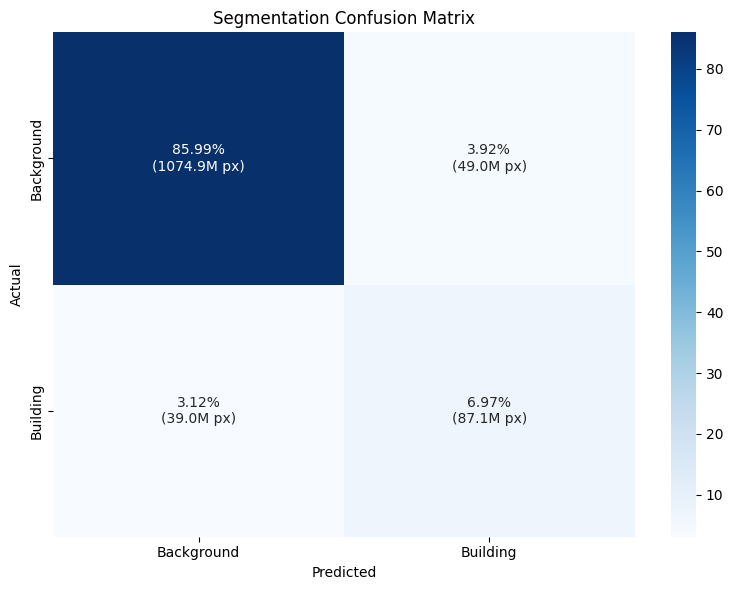


Total pixels: 1.25B
TP: 87.1M, TN: 1074.9M
FP: 49.0M, FN: 39.0M


In [17]:
# 7.2 Confusion Matrix для сегментации (используем кэшированные данные)
total_tp = 0
total_tn = 0
total_fp = 0
total_fn = 0

for image_path, _, _ in tqdm(test_pairs, desc="Computing confusion matrix"):
    # Используем кэшированные маски (без повторной загрузки)
    cached = predictions_cache[image_path.name]
    seg_mask = cached["seg_mask"]
    gt_mask = cached["gt_mask"]
    
    tp = np.sum((seg_mask == 1) & (gt_mask == 1))
    tn = np.sum((seg_mask == 0) & (gt_mask == 0))
    fp = np.sum((seg_mask == 1) & (gt_mask == 0))
    fn = np.sum((seg_mask == 0) & (gt_mask == 1))
    
    total_tp += tp
    total_tn += tn
    total_fp += fp
    total_fn += fn

# Confusion matrix plot
cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
cm_normalized = cm / cm.sum() * 100

fig, ax = plt.subplots(figsize=(8, 6))
# Формируем аннотации с процентами и абсолютными значениями
annot_labels = np.array([
    [f"{cm_normalized[i, j]:.2f}%\n({cm[i, j] / 1e6:.1f}M px)" for j in range(2)]
    for i in range(2)
])
sns.heatmap(
    cm_normalized, annot=annot_labels, fmt="", cmap="Blues",
    xticklabels=["Background", "Building"],
    yticklabels=["Background", "Building"],
    ax=ax
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Segmentation Confusion Matrix")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nTotal pixels: {cm.sum() / 1e9:.2f}B")
print(f"TP: {total_tp / 1e6:.1f}M, TN: {total_tn / 1e6:.1f}M")
print(f"FP: {total_fp / 1e6:.1f}M, FN: {total_fn / 1e6:.1f}M")

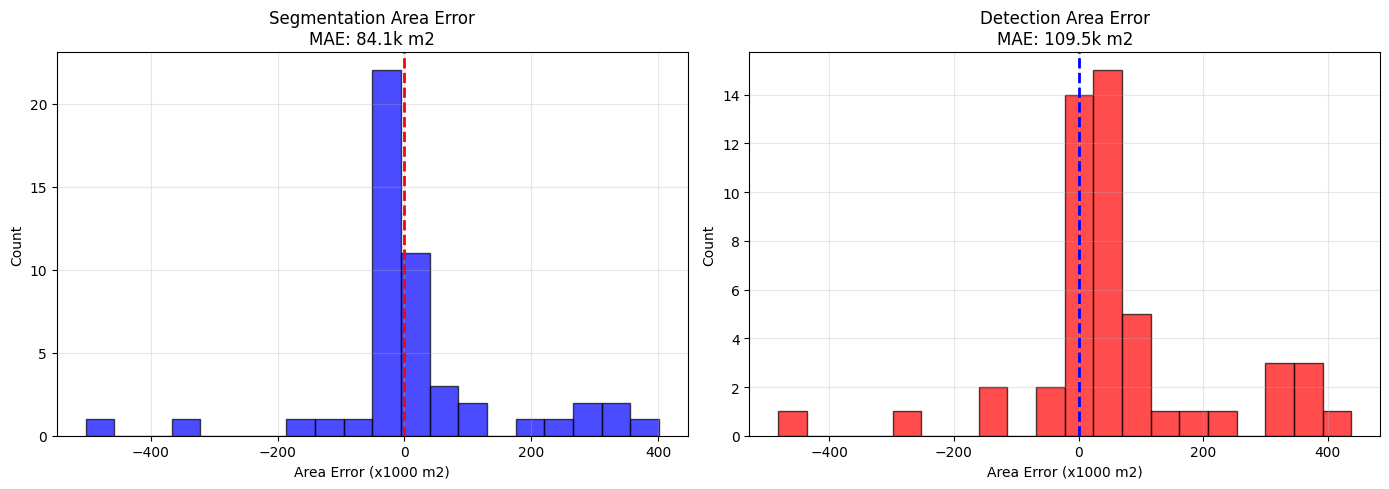

In [18]:
# 7.3 Гистограммы ошибок площади
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segmentation errors
axes[0].hist(df["seg_area_error"] / 1000, bins=20, color="blue", alpha=0.7, edgecolor="black")
axes[0].axvline(0, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("Area Error (x1000 m2)")
axes[0].set_ylabel("Count")
axes[0].set_title(f"Segmentation Area Error\nMAE: {df['seg_area_error'].abs().mean() / 1000:.1f}k m2")
axes[0].grid(True, alpha=0.3)

# Detection errors
axes[1].hist(df["det_area_error"] / 1000, bins=20, color="red", alpha=0.7, edgecolor="black")
axes[1].axvline(0, color="blue", linestyle="--", linewidth=2)
axes[1].set_xlabel("Area Error (x1000 m2)")
axes[1].set_ylabel("Count")
axes[1].set_title(f"Detection Area Error\nMAE: {df['det_area_error'].abs().mean() / 1000:.1f}k m2")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "area_errors.png", dpi=150, bbox_inches="tight")
plt.show()

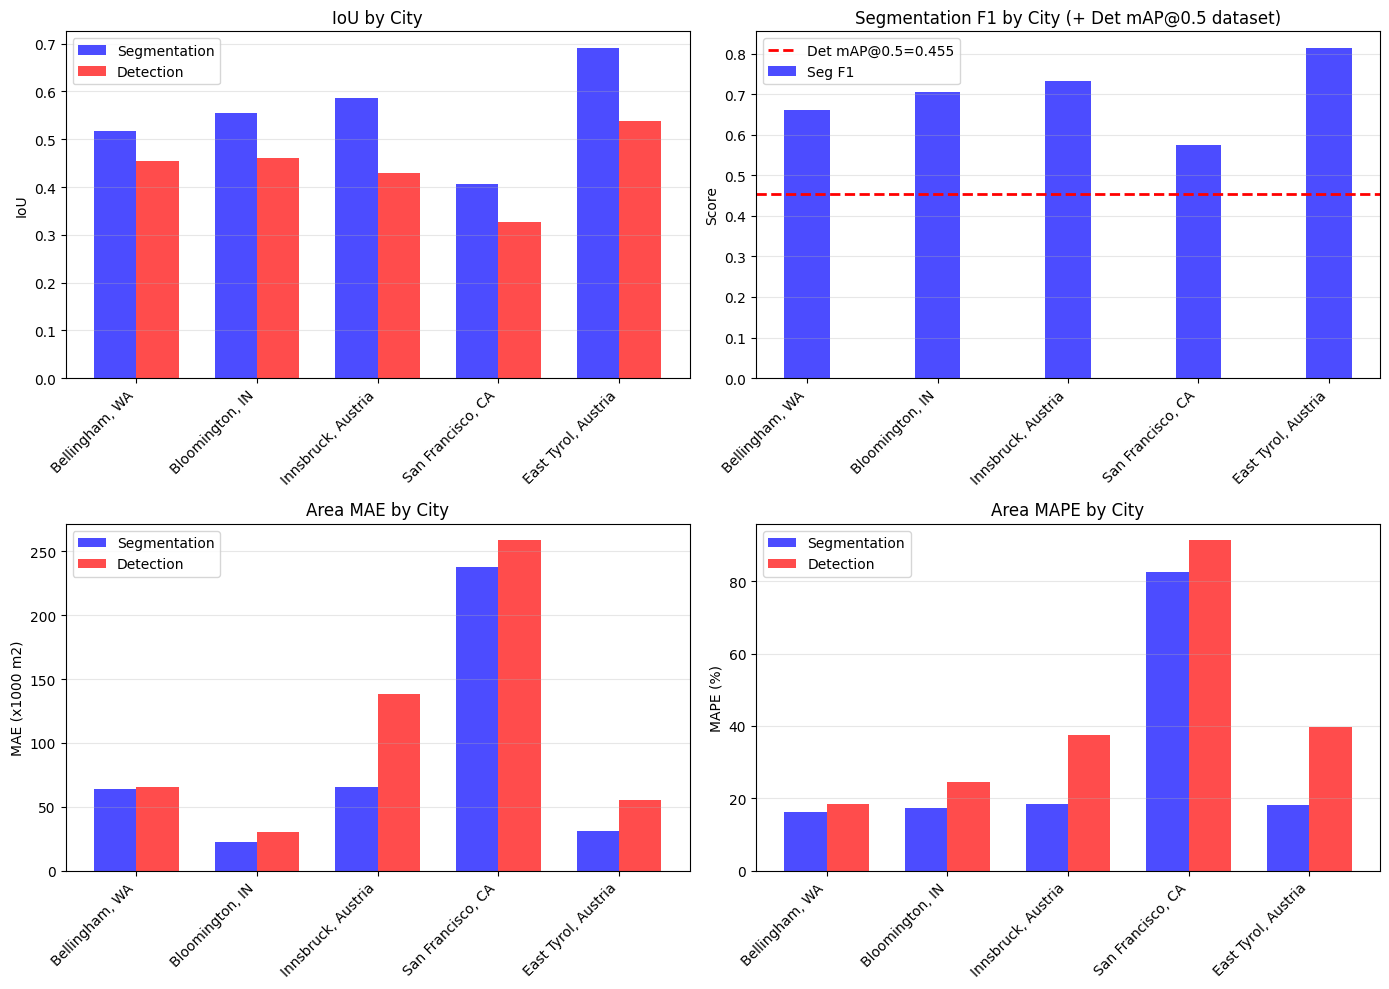

In [19]:
# 7.4 Сравнение по городам
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

cities = list(CITY_MAPPING.keys())
city_names = [CITY_MAPPING[c] for c in cities]
x = np.arange(len(cities))
width = 0.35

# IoU comparison
seg_ious = [city_metrics.loc[c, "seg_iou"] for c in cities]
det_ious = [city_metrics.loc[c, "det_iou"] for c in cities]
axes[0, 0].bar(x - width/2, seg_ious, width, label="Segmentation", color="blue", alpha=0.7)
axes[0, 0].bar(x + width/2, det_ious, width, label="Detection", color="red", alpha=0.7)
axes[0, 0].set_ylabel("IoU")
axes[0, 0].set_title("IoU by City")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(city_names, rotation=45, ha="right")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis="y")

# F1 comparison (mAP вычисляется на всём датасете, показываем только F1)
seg_f1s = [city_metrics.loc[c, "seg_f1"] for c in cities]
axes[0, 1].bar(x, seg_f1s, width, label="Seg F1", color="blue", alpha=0.7)
axes[0, 1].axhline(dataset_map50, color="red", linestyle="--", linewidth=2, label=f"Det mAP@0.5={dataset_map50:.3f}")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_title("Segmentation F1 by City (+ Det mAP@0.5 dataset)")
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(city_names, rotation=45, ha="right")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis="y")

# MAE comparison
seg_maes = [city_metrics.loc[c, "seg_mae_m2"] / 1000 for c in cities]
det_maes = [city_metrics.loc[c, "det_mae_m2"] / 1000 for c in cities]
axes[1, 0].bar(x - width/2, seg_maes, width, label="Segmentation", color="blue", alpha=0.7)
axes[1, 0].bar(x + width/2, det_maes, width, label="Detection", color="red", alpha=0.7)
axes[1, 0].set_ylabel("MAE (x1000 m2)")
axes[1, 0].set_title("Area MAE by City")
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(city_names, rotation=45, ha="right")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis="y")

# MAPE comparison
seg_mapes = [city_metrics.loc[c, "seg_mape"] for c in cities]
det_mapes = [city_metrics.loc[c, "det_mape"] for c in cities]
axes[1, 1].bar(x - width/2, seg_mapes, width, label="Segmentation", color="blue", alpha=0.7)
axes[1, 1].bar(x + width/2, det_mapes, width, label="Detection", color="red", alpha=0.7)
axes[1, 1].set_ylabel("MAPE (%)")
axes[1, 1].set_title("Area MAPE by City")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(city_names, rotation=45, ha="right")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "city_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Сравнительная таблица

In [20]:
# Формирование итоговой таблицы
comparison_data = []

for city in CITY_MAPPING.keys():
    row = city_metrics.loc[city]
    comparison_data.append({
        "City": CITY_MAPPING[city],
        "Seg IoU": f"{row['seg_iou']:.3f}",
        "Seg F1": f"{row['seg_f1']:.3f}",
        "Seg MAE (m2)": f"{row['seg_mae_m2']:.0f}",
        "Det IoU": f"{row['det_iou']:.3f}",
        "Det MAE (m2)": f"{row['det_mae_m2']:.0f}",
    })

# Overall row (mAP вычисляется на уровне датасета, не по городам)
comparison_data.append({
    "City": "**OVERALL**",
    "Seg IoU": f"{df['seg_iou'].mean():.3f}",
    "Seg F1": f"{df['seg_f1'].mean():.3f}",
    "Seg MAE (m2)": f"{df['seg_area_error'].abs().mean():.0f}",
    "Det IoU": f"{df['det_iou'].mean():.3f}",
    "Det MAE (m2)": f"{df['det_area_error'].abs().mean():.0f}",
})

comparison_df = pd.DataFrame(comparison_data)

# Отдельно выводим mAP (вычисляется на всём датасете)
print(f"Detection mAP@0.5 (dataset): {dataset_map50:.3f}")
print(f"Detection mAP@[.5:.95] (dataset): {dataset_map_coco:.3f}")
print()
comparison_df

Detection mAP@0.5 (dataset): 0.455
Detection mAP@[.5:.95] (dataset): 0.209



,City,Seg IoU,Seg F1,Seg MAE (m2),Det IoU,Det MAE (m2)
0,"Bellingham, WA",0.517,0.662,64057,0.454,65254
1,"Bloomington, IN",0.554,0.706,22252,0.461,30579
2,"Innsbruck, Austria",0.587,0.733,65256,0.429,138010
3,"San Francisco, CA",0.407,0.576,237720,0.327,258605
4,"East Tyrol, Austria",0.691,0.815,31200,0.538,54959
5,**OVERALL**,0.551,0.698,84097,0.442,109481


In [21]:
# Определение лучшей модели для оценки площади
seg_mape = df["seg_area_error_pct"].mean()
det_mape = df["det_area_error_pct"].mean()

print("=" * 60)
print("BEST MODEL FOR AREA ESTIMATION")
print("=" * 60)
print(f"\nSegmentation MAPE: {seg_mape:.2f}%")
print(f"Detection MAPE: {det_mape:.2f}%")

if seg_mape < det_mape:
    print(f"\n-> Segmentation is better for area estimation (by {det_mape - seg_mape:.2f}%)")
    best_model = "Segmentation"
else:
    print(f"\n-> Detection is better for area estimation (by {seg_mape - det_mape:.2f}%)")
    best_model = "Detection"

BEST MODEL FOR AREA ESTIMATION

Segmentation MAPE: 30.51%
Detection MAPE: 42.25%

-> Segmentation is better for area estimation (by 11.74%)


## 9. Сохранение результатов и выводы

In [22]:
# Сохранение всех результатов в JSON
evaluation_results = {
    "config": {
        "gsd_m_per_pixel": GSD,
        "seg_tile_size": SEG_TILE_SIZE,
        "det_tile_size": DET_TILE_SIZE,
        "det_score_thresh": DET_SCORE_THRESH,
        "num_test_images": len(test_pairs),
    },
    "overall": {
        "segmentation": {
            "iou": float(df["seg_iou"].mean()),
            "f1": float(df["seg_f1"].mean()),
            "precision": float(df["seg_precision"].mean()),
            "recall": float(df["seg_recall"].mean()),
            "mae_m2": float(df["seg_area_error"].abs().mean()),
            "mape_percent": float(seg_mape),
        },
        "detection": {
            "map50": float(dataset_map50),  # Вычислено на всём датасете
            "map_coco": float(dataset_map_coco),  # Вычислено на всём датасете
            "iou_from_boxes": float(df["det_iou"].mean()),
            "mae_m2": float(df["det_area_error"].abs().mean()),
            "mape_percent": float(det_mape),
        },
    },
    "per_city": {},
    "best_model_for_area": best_model,
}

# Per-city results (mAP вычисляется только на уровне датасета)
for city in CITY_MAPPING.keys():
    row = city_metrics.loc[city]
    evaluation_results["per_city"][city] = {
        "full_name": CITY_MAPPING[city],
        "num_images": int(row["num_images"]),
        "segmentation": {
            "iou": float(row["seg_iou"]),
            "f1": float(row["seg_f1"]),
            "mae_m2": float(row["seg_mae_m2"]),
            "mape_percent": float(row["seg_mape"]),
        },
        "detection": {
            "iou_from_boxes": float(row["det_iou"]),
            "mae_m2": float(row["det_mae_m2"]),
            "mape_percent": float(row["det_mape"]),
        },
    }

# Сохранение
results_path = OUTPUT_DIR / "test_evaluation_results.json"
with open(results_path, "w", encoding="utf-8") as f:
    json.dump(evaluation_results, f, indent=2, ensure_ascii=False)

print(f"Results saved to: {results_path}")

Results saved to: /home/user/code/dls_project/checkpoints/test_evaluation/test_evaluation_results.json


In [23]:
# Также сохраняем детальные результаты по изображениям
df.to_csv(OUTPUT_DIR / "per_image_results.csv", index=False)
print(f"Per-image results saved to: {OUTPUT_DIR / 'per_image_results.csv'}")

Per-image results saved to: /home/user/code/dls_project/checkpoints/test_evaluation/per_image_results.csv


## Выводы

### Результаты оценки на тестовых данных

Модели были протестированы на **50 изображениях** из **5 городов**, которые **не участвовали в обучении**:
- Bellingham, WA (США) — 10 изображений
- Bloomington, IN (США) — 10 изображений
- Innsbruck (Австрия) — 10 изображений
- San Francisco, CA (США) — 10 изображений
- East Tyrol (Австрия) — 10 изображений

### Сегментация (UNet-ResNet50, 47.5M параметров)

| Метрика | Значение |
|---------|----------|
| **IoU** | 0.5511 |
| **F1-score** | 0.6981 |
| **Precision** | 0.7394 |
| **Recall** | 0.7096 |
| **MAE площади** | 84,097 м² |
| **MAPE площади** | 30.51% |

### Детекция (Faster R-CNN, 41.3M параметров)

| Метрика | Значение |
|---------|----------|
| **mAP@0.5** | 0.4549 |
| **mAP@[0.5:0.95]** | 0.2090 |
| **IoU (boxes→mask)** | 0.4418 |
| **MAE площади** | 109,481 м² |
| **MAPE площади** | 42.25% |

### Результаты по городам

| Город | Seg IoU | Seg MAPE | Det IoU | Det MAPE |
|-------|---------|----------|---------|----------|
| **East Tyrol** (лучший) | 0.6914 | 18.15% | 0.5375 | 39.59% |
| Innsbruck | 0.5868 | 18.30% | 0.4288 | 37.38% |
| Bloomington | 0.5544 | 17.32% | 0.4609 | 24.48% |
| Bellingham | 0.5166 | 16.30% | 0.4544 | 18.53% |
| **San Francisco** (худший) | 0.4066 | 82.50% | 0.3274 | 91.28% |

### Ключевые выводы

1. **Сегментация превосходит детекцию** по всем метрикам качества:
   - IoU: 0.5511 vs 0.4418 (+24.7%)
   - MAPE: 30.51% vs 42.25% (точнее на 11.74 п.п.)

2. **Лучшая генерализация на альпийских городах** (East Tyrol, Innsbruck) — IoU 0.59-0.69, возможно из-за схожести с австрийскими городами в обучающей выборке (Vienna, Kitsap)

3. **San Francisco — аномалия**: MAPE 82-91% свидетельствует о сильном domain shift (высотная плотная застройка отличается от обучающих городов)

4. **Рекомендация для оценки площади застройки**: использовать модель сегментации (MAPE 30.5% vs 42.3% у детекции)

5. **Потенциал улучшения**: добавление городов с высотной застройкой в обучающую выборку должно улучшить генерализацию на San Francisco